<h3> Cleaning scraped data. </h3>
<p>
    Ses données on été scrapées sur plusieurs platforms. L'idée c'est de nettoyer ses données et les analysées.
</p>
<h3> Dépendances </h3>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns

<h3> Chargement des fichiers de données et creation des DFs </h3>

In [2]:
def readDoorInsider(file_path):
    with open(file_path, encoding='utf-8') as f:
        data = json.load(f)

    result = []
    for df in data:
        df['surface_terrain'] = df['features']['Géneral'].get('Surface loi Carrez ', 0)
        df['nbSalleBain'] = df['features']['Géneral'].get('Salle(s) de bain', 0)
        df['balcon'] = 'Oui' if 'Chauffage' in df['features'] and 'Balcon' in df['features']['Chauffage'] else 'Non'
        df['terrace'] = 'Oui' if 'Chauffage' in df['features'] and 'Terrasse' in df['features']['Chauffage'] else 'Non'
        df['jardin'] = 'Oui' if 'Chauffage' in df['features'] and 'Jardin' in df['features']['Chauffage'] else 'Non'
        df['cuisine'] = 'Oui' if 'Cuisine' in df['features']  else 'Non'
        df['garage'] = 'Oui' if 'Chauffage' in df['features'] and 'Place de parking' in df['features']['Chauffage'] else 'Non'
        df['classEnergy'] = df['features'].get('classEnergy', 'ND')
        df['gazEmission'] = df['features'].get('gazEmission', 'ND')
        result.append(df)
        df.pop('features', None)

    return result

def readImmoRegion(file_path):
    with open(file_path, encoding='utf-8') as f:
        data = json.load(f)
    result = []
    for df in data:
        df['nbSalleBain'] = df.pop('toilletes')
        df['garage'] = df.pop('parking')
        if 'features' in df:
            df['surface_terrain'] = df['features'].get('Surface habitable', 0)
            df['balcon'] = 'Non'
            df['terrace'] = 'Oui' if 'Terrasse' in df['features'] else 'Non'
            df['cuisine'] = 'Oui' if 'Cuisine équipée' in df['features'] else 'Non'
            df['jardin'] = 'Oui' if 'Jardin' in df['features'] else 'Non'
            df['garage'] = 'Oui' if 'Place(s) de parking dans un garage' in df['features']  else 'Non'
            df['classEnergy'] = df['features'].get('Diagnostique de performance énergétique (DPE)Réalisé avant le 1er juillet 2021Logement à consommation énergétique excessive', 'ND')
            df['gazEmission'] = df['features'].get('Emission de gaz à effet de serre (GES)', 'ND')
            result.append(df)
            df.pop('features', None)
        else:
            result.append(df)
    return result

def readparuVenu(file_path):
    with open(file_path, encoding='utf-8') as f:
        data = json.load(f)
    result = []
    for df in data:
        df.pop('toilletes')
        df['garage'] = df.pop('parking')
        if 'features' in df:
            df['surface_terrain'] = df['features'].get('- Surface du terrain', 0)
            df['nbSalleBain'] = df['features'].get('- Nombre de salle(s) de bain', 0)
            df['balcon'] = 'Non'
            df['terrace'] = 'Oui' if 'Terrasse' in df['features'] else 'Non'
            df['jardin'] = 'Oui' if '- Mobilier de jardin' in df['features'] else 'Non'
            df['garage'] = 'Oui' if '- Garage extérieur' in df['features']  else 'Non'
            df['garage'] = 'Oui' if '- Parking' in df['features']  else 'Non'
            df['classEnergy'] = df['features'].get('classEnergy', 'ND')
            df['gazEmission'] = df['features'].get('gazEmission', 'ND')
            result.append(df)
            df.pop('features', None)
        else:
            result.append(df)
    return result




In [3]:
file1='../ScrappingV2/doorInsider/output/output.json'
doorInsider = readDoorInsider(file1)

In [4]:
file2='../ScrappingV2/immoRegion/output/output.json'
immoRegion = readImmoRegion(file2)

In [5]:
file3='../ScrappingV2/paruvenu/output/output.json'
paruVenu = readparuVenu(file3)

In [6]:
merged_list = []
merged_list.extend(paruVenu)
merged_list.extend(immoRegion)
merged_list.extend(doorInsider)

df = pd.DataFrame(merged_list)

<h3> Numerisation de certains valeurs </h3>

In [7]:
import re
# function to clean the pieces column
def clean_pieces(data):
    # convert non-string values to string
    data = str(data)
    
    # remove special characters and keep only numeric values
    data = re.sub('[^0-9]', '', data)
    
    # return the cleaned value as an integer
    return int(data) if data else None

# apply the clean_pieces function to the pieces column
df['pieces'] = df['pieces'].apply(clean_pieces)
df['surface_terrain'] = df['surface_terrain'].apply(clean_pieces)
df['nbSalleBain'] = df['nbSalleBain'].apply(clean_pieces)

In [8]:
df.dtypes

title               object
url                 object
ref                 object
typeBien            object
ville               object
price              float64
surface            float64
pieces             float64
chambres           float64
cuisine             object
description         object
image               object
garage              object
surface_terrain    float64
nbSalleBain          int64
balcon              object
terrace             object
jardin              object
classEnergy         object
gazEmission         object
dtype: object

<h4> Suppression de doublons</h4>
<p> La colonne ref est la référence d'une annonce donc les valeurs doivent être unique </p>

In [9]:
duplicate_ref = df.duplicated(subset='ref', keep=False)
number_of_duplicate = duplicate_ref.sum()
print(number_of_duplicate)

4


In [10]:
## we will drop the the duplicate
duplicate_ref = df.duplicated(subset='ref', keep=False)
df = df.drop_duplicates(subset='ref', keep='first')


<h4> Verification du percentage de valeurs null dans chaque colonne <h4>

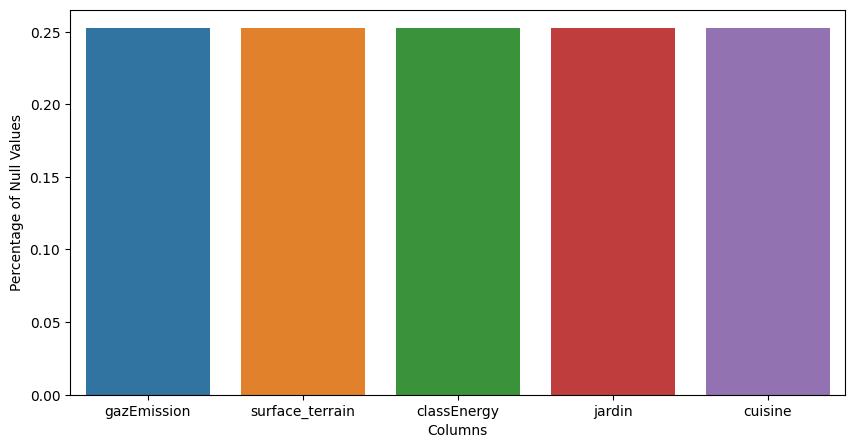

In [11]:
# Calculate the percentage of null values in each column
null_vals = df.isnull().mean()
null_vals = null_vals.sort_values(ascending=False).head(5)
plt.figure(figsize=(10,5))
sns.barplot(x=null_vals.index, y=null_vals.values)
plt.xlabel('Columns')
plt.ylabel('Percentage of Null Values')
plt.show()



<h3> Suppression de certains columns qui vont faire partir de l'analyse </h3>

In [12]:
df = df.drop(["image","url","description"], axis=1)

<h3> Univariate Analysis </h3>

In [13]:
def countPlot(df:pd.DataFrame,x:str, percent:bool=True, size=(15,5))->None: # to plot a bargraph of percentage frequencies of a column
    plt.figure(figsize=size)
    chart = sns.countplot(
        data=df,
        x=x,
        order=df[x].value_counts().index
    )
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

    if percent==True: # to add value on the bar as percentage
        total = len(df[x])
        for p in chart.patches:
                percentage = f'{100 * p.get_height() / total:.3f}%\n'
                x = p.get_x() + p.get_width() / 2
                y = p.get_height()
                chart.annotate(percentage, (x, y), ha='center', va='center')
    else:
        chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
        for c in chart.containers:
            labels = [f'{(v.get_height()):.1f}' for v in c]
            chart.bar_label(c, labels=labels, label_type='edge')
    plt.ylabel('Percentage')
    plt.show()

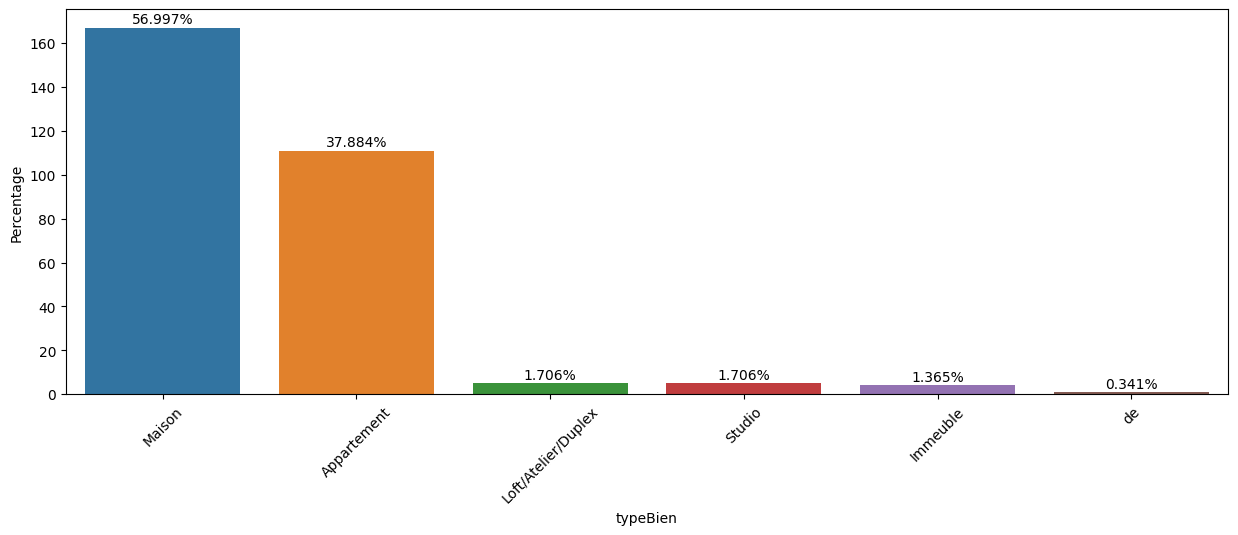

In [14]:
df_TypeVente = df.copy()
df_TypeVente = df_TypeVente.groupby('typeBien').filter(lambda x: len(x) > 0)
countPlot(df_TypeVente, "typeBien", True)

In [15]:
df.columns

Index(['title', 'ref', 'typeBien', 'ville', 'price', 'surface', 'pieces',
       'chambres', 'cuisine', 'garage', 'surface_terrain', 'nbSalleBain',
       'balcon', 'terrace', 'jardin', 'classEnergy', 'gazEmission'],
      dtype='object')

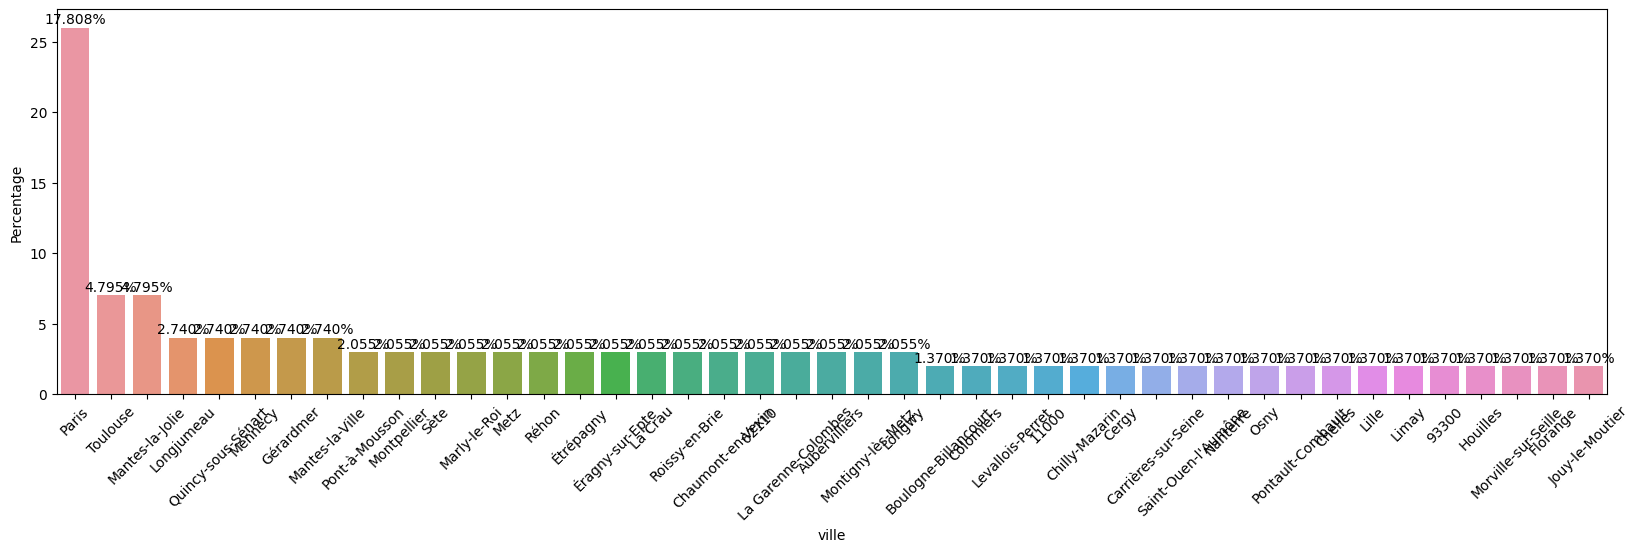

In [16]:
df_ville = df.copy()
df_ville = df_ville.groupby('ville').filter(lambda x: len(x) > 1)
countPlot(df_ville, "ville", True, (20,5))

In [17]:
df_ville

,title,ref,typeBien,ville,price,surface,pieces,chambres,cuisine,garage,surface_terrain,nbSalleBain,balcon,terrace,jardin,classEnergy,gazEmission
13,Annonce : Vente Maison Nanterre (92000) 164 m²...,992769679780,Maison,Nanterre,940000.0,164.0,6.0,0.0,Oui,Non,3902.0,0,Non,Non,Non,A,NC
14,Annonce : Vente Maison Nanterre (92000) 152 m²...,992769679782,Maison,Nanterre,860000.0,152.0,7.0,0.0,Oui,Non,3902.0,0,Non,Non,Non,A,NC
19,"▷ Appartement en vente • Gérardmer • 62,88 m² ...",7880093,Appartement,Gérardmer,199000.0,63.0,3.0,1.0,NaN,1,NaN,2,NaN,NaN,NaN,NaN,NaN
21,▷ Maison en vente • Gérardmer • 336 m² • 265 0...,7880091,Maison,Gérardmer,265000.0,336.0,11.0,6.0,NaN,2,NaN,0,NaN,NaN,NaN,NaN,NaN
22,"▷ Maison en vente • Gérardmer • 195,12 m² • 57...",7880090,Maison,Gérardmer,577500.0,195.0,16.0,9.0,NaN,10,NaN,3,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,Studio - 1 pièce - 28.4 m² - Quincy-sous-Sénar...,9979,Studio,Quincy-sous-Sénart,145000.0,28.0,1.0,1.0,Oui,Oui,0.0,1,Oui,Non,Non,C,C
289,Maison - 4 pièces - 114 m² - Carrières-sur-Sei...,10006,Maison,Carrières-sur-Seine,749000.0,114.0,4.0,2.0,Oui,Non,0.0,1,Non,Oui,Non,none,none
290,Maison - 5 pièces - 83 m² - Cergy - 95800,10028,Maison,Cergy,358700.0,83.0,5.0,4.0,Oui,Non,0.0,1,Non,Oui,Oui,none,none
291,Appartement - 3 pièces - 55.55 m² - Jouy-le-Mo...,10021,Appartement,Jouy-le-Moutier,180000.0,55.0,3.0,2.0,Oui,Non,0.0,1,Non,Oui,Non,D,B


In [18]:
def plot_boxplots(df: pd.DataFrame, column:str):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
    axes[0].set_title(column[0])
    axes[1].set_title(column[1])
    axes[2].set_title(column[2])
    df.boxplot(column[0], ax=axes[0], vert=False)
    df.boxplot(column[1], ax=axes[1], vert=False)
    df.boxplot(column[2], ax=axes[2], vert=False)
    fig.suptitle("Boxplots du dataset")
    # Remove the automatic label generation on plots
    axes[0].set_yticklabels([""])
    axes[1].set_yticklabels([""])
    axes[2].set_yticklabels([""])
    plt.show()
def plot_histogram(df: pd.DataFrame, column:str):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
    axes[0].set_title(column[0])
    axes[1].set_title(column[1])
    axes[2].set_title(column[2])
    df[column[0]].hist(bins=100, ax=axes[0])
    df[column[1]].hist(bins=100, ax=axes[1])
    df[column[2]].hist(bins=100, ax=axes[2])
    fig.suptitle("Distribution du dataset")
    # Remove the automatic label generation on plots
   
    plt.show()

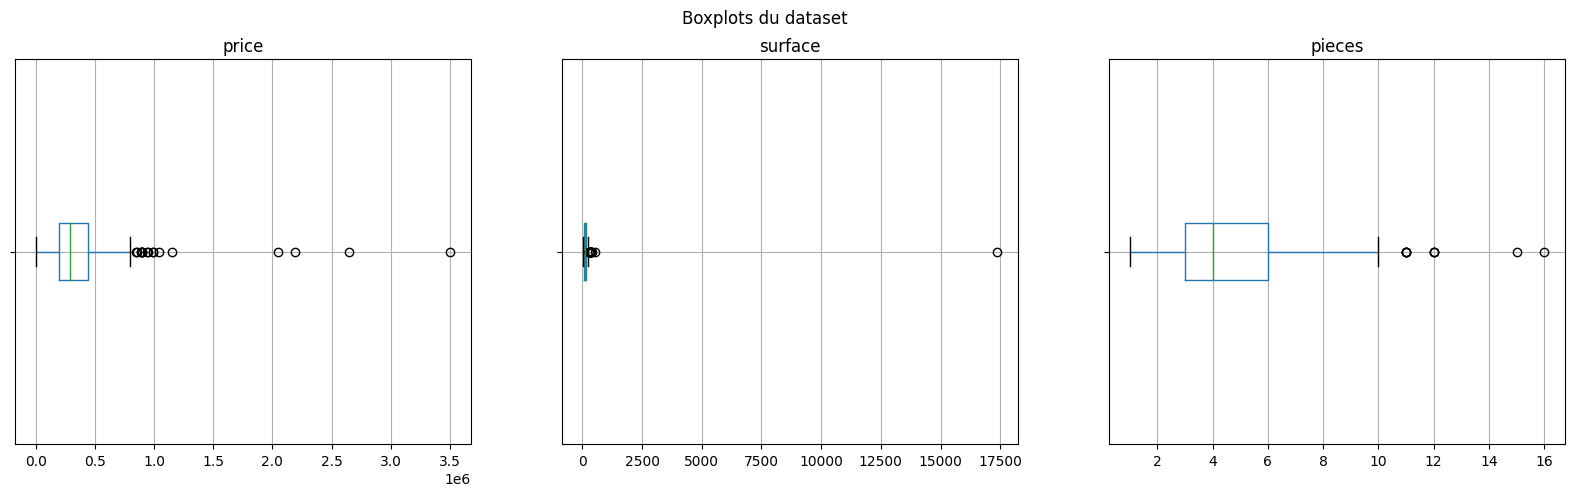

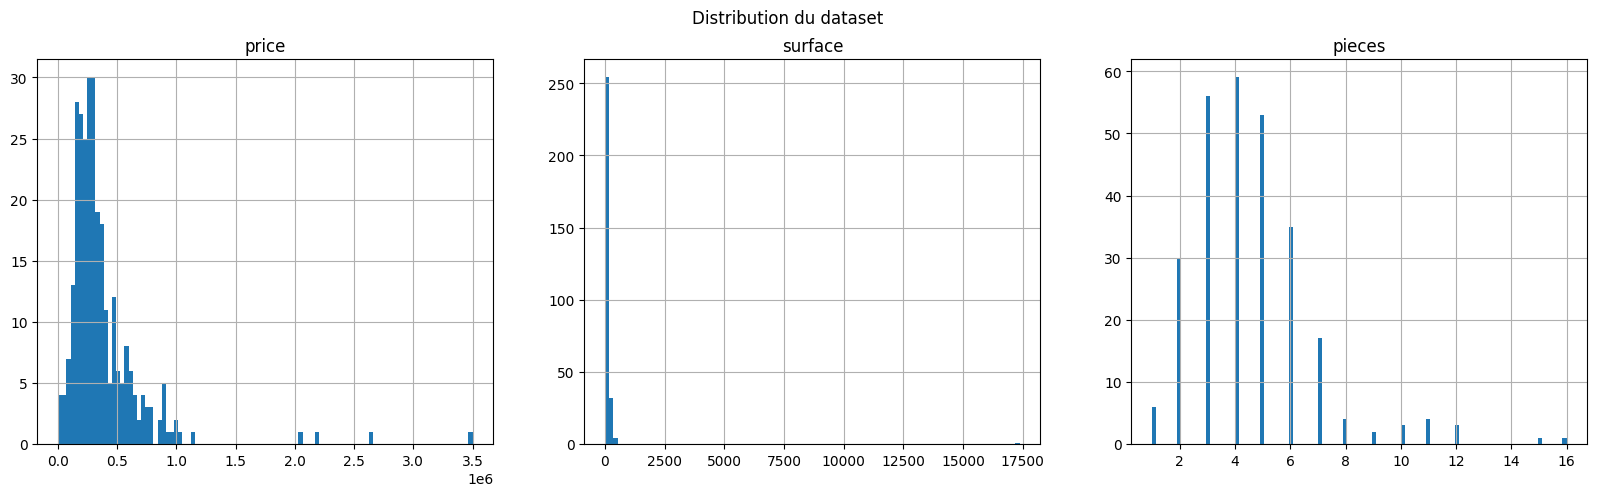

In [19]:
plot_boxplots(df, ["price", "surface", "pieces"])
plot_histogram(df,["price", "surface", "pieces"])

In [20]:
df['nbSalleBain']

0      0
1      0
2      0
3      0
4      0
      ..
290    1
291    1
292    1
293    0
294    1
Name: nbSalleBain, Length: 293, dtype: int64

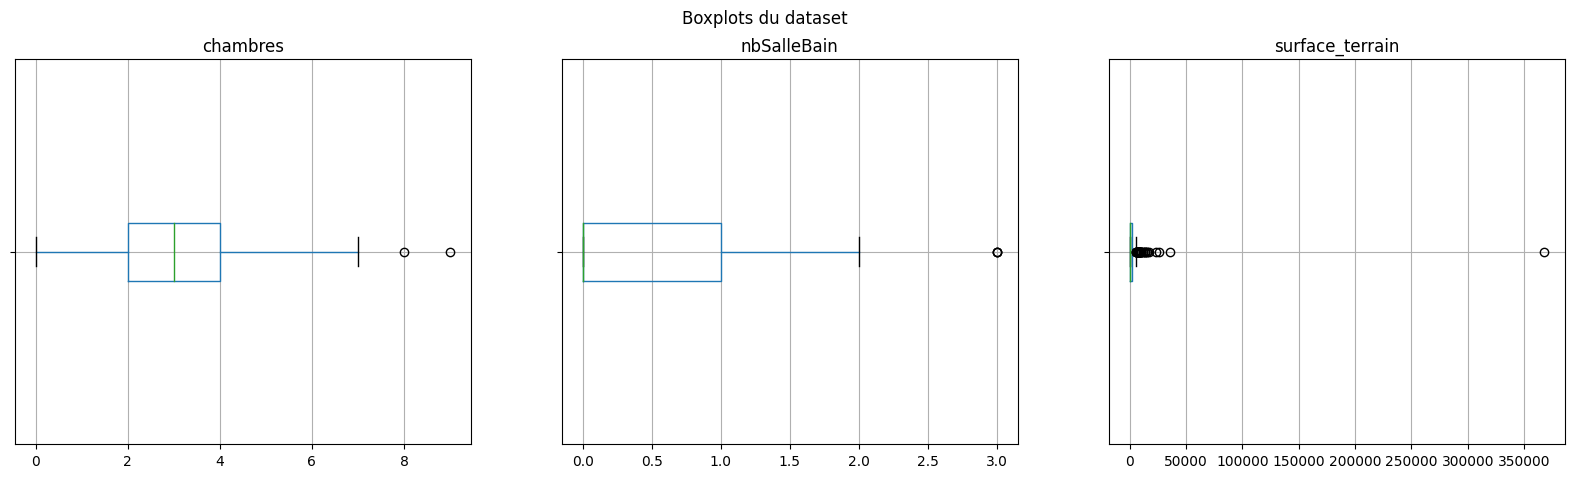

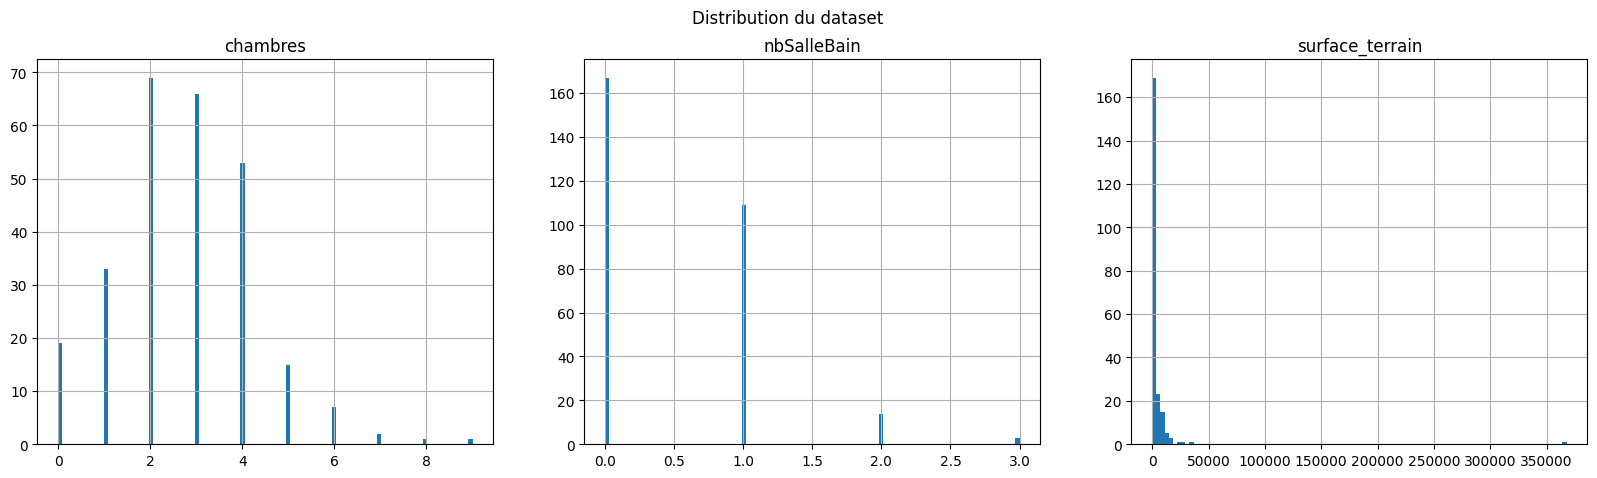

In [21]:
plot_boxplots(df, ["chambres", "nbSalleBain", "surface_terrain"])
plot_histogram(df,["chambres", "nbSalleBain", "surface_terrain"])

<h4> Suppression des outliers: </h4>
<p> 
    on va utiliser deux methodes percentiles et quartile.
</p>

<p> 
    on va definir une fonction permettant d'afficher la distribution d'une valeur avec une mise en valeur des outliers.
</p>

In [22]:
from typing import Union, Any, List, Iterable, Tuple, Dict, Callable

def plot_distribution_with_bounds(
    series: pd.Series,  
    bounds: Tuple[float, float],
    ax: plt.Axes = None,
    title: str = "",
    figsize: Tuple[float, float] = (10, 5),
    bins: int = 100,
):
    series.plot.hist(bins=bins, ax=ax)

    min, max = bounds
    ax.axvspan(0.0, min, color="red", alpha=0.5)
    ax.axvspan(max, series.max(), color="red", alpha=0.5)

In [23]:
def display_outliers_method(
    df: pd.DataFrame, 
    columns,
    method: Callable[[pd.Series, Any], Tuple[float, float]],
    **kwargs
):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 5))
    axes[0].set_title(columns[0])
    axes[1].set_title(columns[0])
    axes[2].set_title(columns[0])

    for idx, col in zip(range(3), columns):
        ax = axes[idx]
        ax.set_title(col)
        series = df[col]
        bounds = method(series, **kwargs)
        print(f"Bounds for column \"{col}\": {bounds}")
        plot_distribution_with_bounds(
            series,
            bounds,
            ax
        )
    plt.show()

<h4> Methode percentile : </h4>

In [24]:
def compute_percentile_bounds(
    series: pd.Series, 
    cutoff_percentage: float = 1.0
) -> Tuple[float, float]:
    """ Returns (lower, upper) bounds
    """
    quantile = cutoff_percentage / 100.0
    return series.quantile(quantile), series.quantile(1 - quantile)

Bounds for column "price": (18970.0, 2059500.0000000033)
Bounds for column "surface": (21.8, 373.3000000000003)
Bounds for column "pieces": (1.0, 12.0)


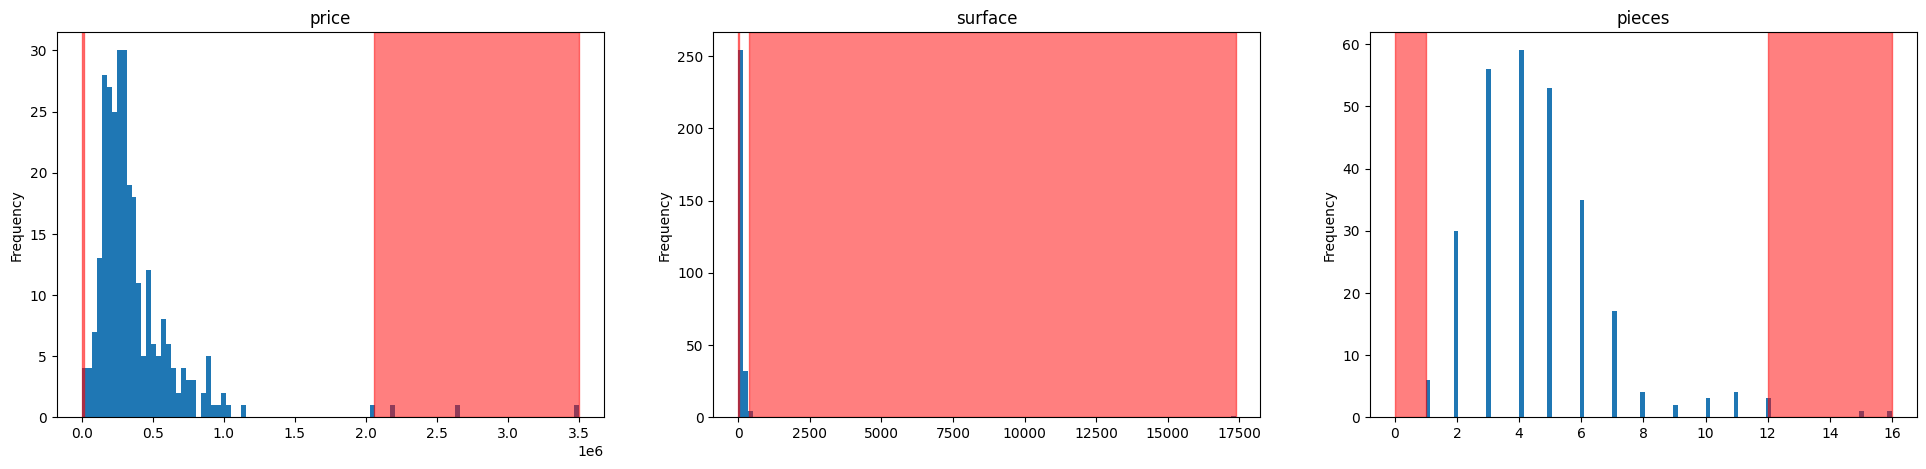

Bounds for column "chambres": (0.0, 7.0)
Bounds for column "nbSalleBain": (0.0, 2.079999999999984)
Bounds for column "surface_terrain": (0.0, 25591.59999999998)


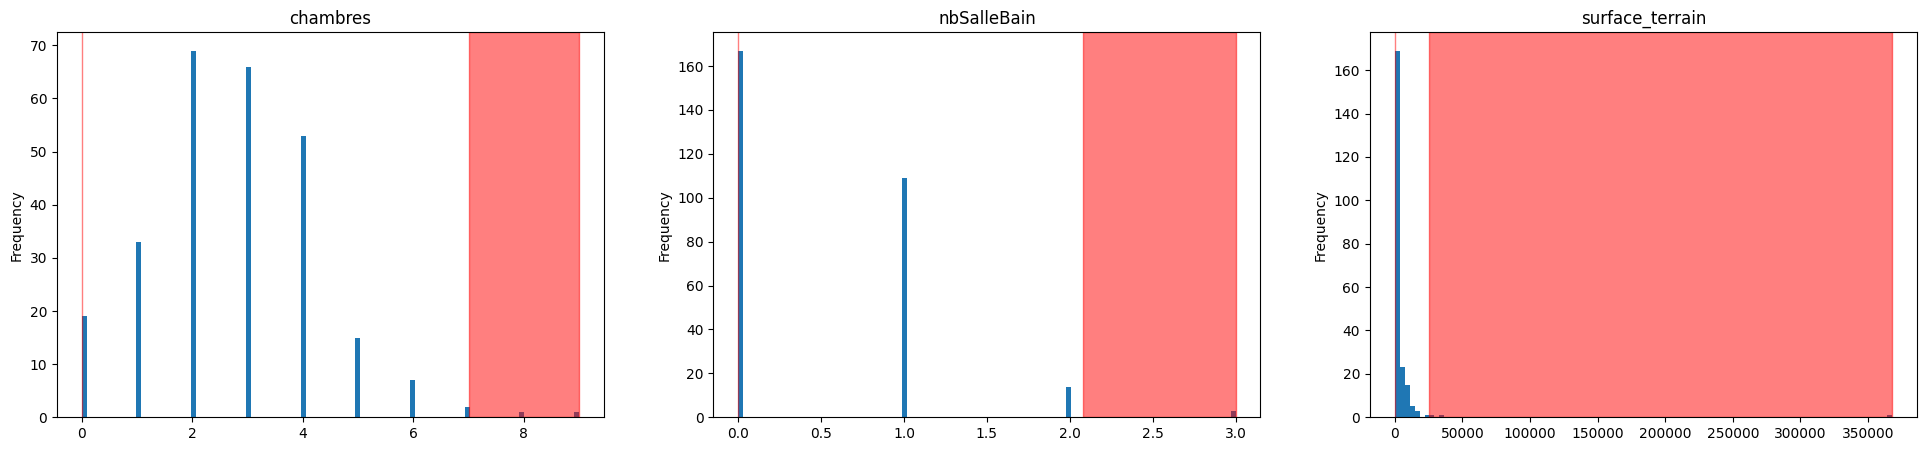

In [25]:
display_outliers_method(
    df,
    ("price", "surface", "pieces"),
    compute_percentile_bounds,
    cutoff_percentage = 1.0
)
display_outliers_method(
    df,
    ("chambres", "nbSalleBain", "surface_terrain"),
    compute_percentile_bounds,
    cutoff_percentage = 1.0
)

<h4> Method Interquartile Range: <h4>

In [26]:
def compute_interquartile_range_method(series: pd.Series) -> Tuple[float, float]:
    quantile_25, quantile_75 = series.quantile([0.25, 0.75])
    iqr = quantile_75 - quantile_25
    print(quantile_25, quantile_75)
    print(iqr)
    lower = quantile_25 - 1.5 * iqr
    upper = quantile_75 + 1.5 * iqr
    return lower, upper

Bounds for column "price": (18970.0, 2059500.0000000033)
Bounds for column "surface": (21.8, 373.3000000000003)
Bounds for column "pieces": (1.0, 12.0)


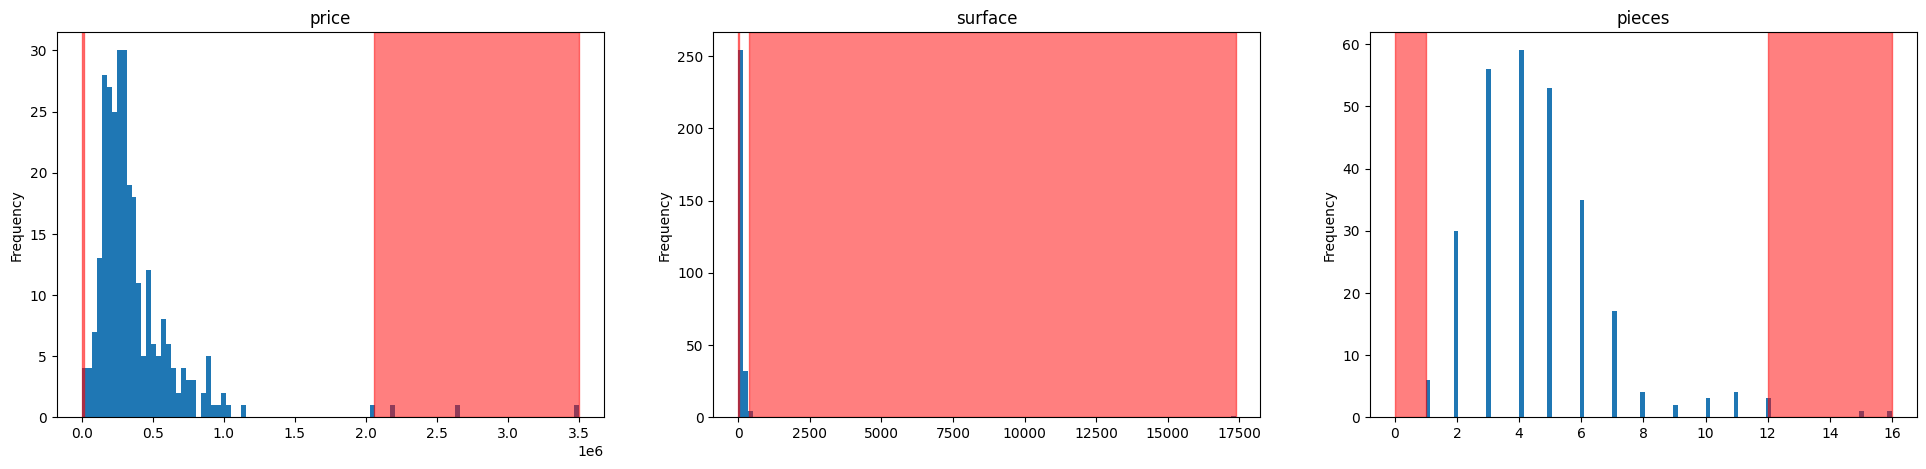

Bounds for column "chambres": (0.0, 7.0)
Bounds for column "nbSalleBain": (0.0, 2.079999999999984)
Bounds for column "surface_terrain": (0.0, 25591.59999999998)


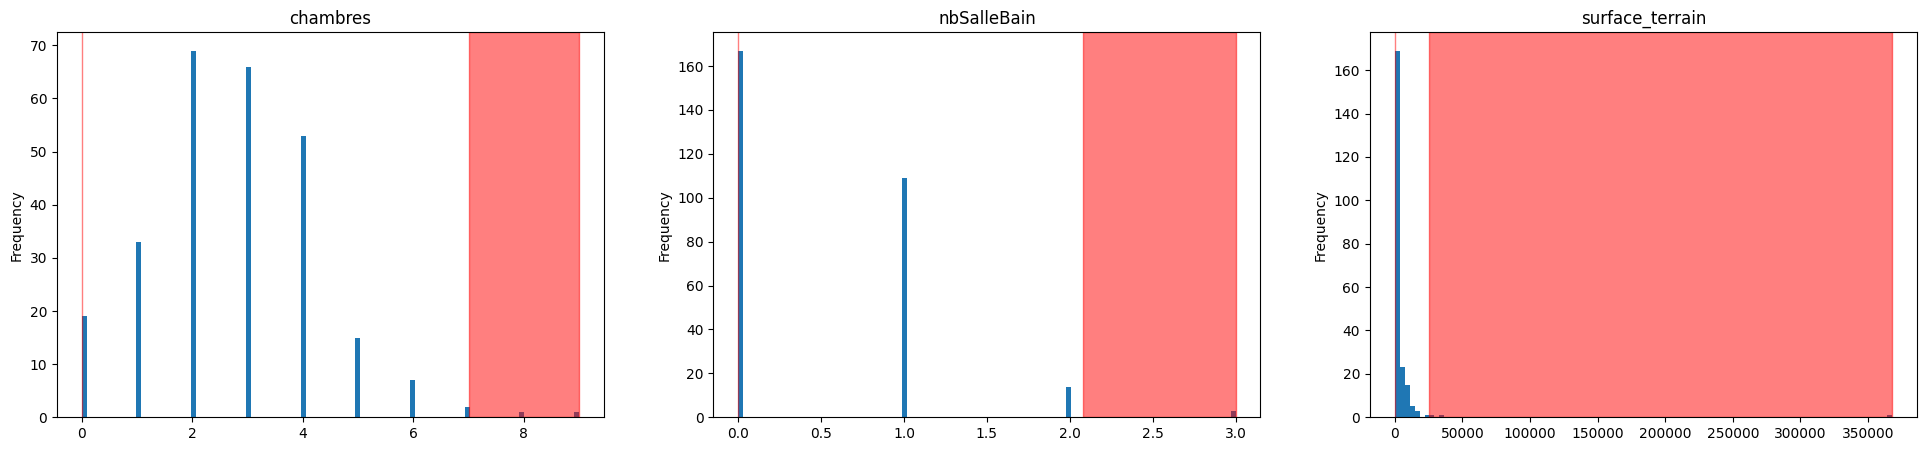

In [27]:
display_outliers_method(
    df,
    ("price", "surface", "pieces"),
    compute_percentile_bounds
)
display_outliers_method(
    df,
    ("chambres", "nbSalleBain", "surface_terrain"),
    compute_percentile_bounds
)

<h4> Comparaison: </h4>
<p> En se basant sur les deux resulats, on peut voir que la methode interquartile range detecte plus d'outliers. Plus d'outliers va resulter à supprimer plus de données. Donc on garde la permière où on supprime peu de données.<p>
<h4> Suppression d'outliers: Methode percentile</h4>


In [28]:
def remove_outliers(
    df: pd.DataFrame, 
    cols,
    method: Callable[[pd.Series, Any, Any], Tuple[float, float]],
    *args,
    **kwargs
) -> pd.DataFrame:
    for col in cols:
        series = df[col]
        bounds = method(series, *args, **kwargs)
        df = df[df[col].between(*bounds, inclusive="both")]
    return df

In [29]:
df = remove_outliers(
    df,
    ("price", "surface", "pieces"),
    compute_percentile_bounds,
    cutoff_percentage=1.0
)

In [31]:
df.to_csv('finalDataset.csv', sep='\t', encoding='utf-8')